# Important links
* Transcriptome data analysis: https://narrative.kbase.us/narrative/108562
* ANME genome: https://narrative.kbase.us/narrative/54879

# Pulling Expression Data

In [6]:
%run anme.py
ws = 108562
expdata = util.msrecon.kbase_api.get_from_ws("CH4_Vs_CH4_AQDS_TPM_ExpressionMatrix",ws)
expdata.data.to_csv(util.output_dir+"/CH4_Vs_CH4_AQDS_TPM_ExpressionMatrix.tsv",sep="\t",index=False)
#msexp = MSExpression.from_gene_feature_file(util.output_dir+"/CH4_Vs_CH4_AQDS_TPM_ExpressionMatrix.tsv")

Output files printed to:/Users/chenry/code/notebooks/ModelSEED2Notebooks/ANME/nboutput when using KBDevUtils.output_dir
Properties:
__dict__
__doc__
__module__
__weakref__
conditions
features
object
type
Functions:
__class__
__delattr__
__dir__
__eq__
__format__
__ge__
__getattribute__
__gt__
__hash__
__init__
__init_subclass__
__le__
__lt__
__ne__
__new__
__reduce__
__reduce_ex__
__repr__
__setattr__
__sizeof__
__str__
__subclasshook__
add_feature
build_reaction_expression
from_gene_feature_file
get_value
Ga0401164_069_2487_2702_gene
Ga0401164_064_20261_20881_gene
Ga0401164_205_26061_26441_gene
Ga0401164_051_2098_2484_gene
Ga0401164_190_3955_5691_gene
Ga0401164_184_3125_3472_gene
Ga0401164_169_2060_2797_gene
Ga0401164_068_474_938_gene
Ga0401164_204_79_393_gene
Ga0401164_062_6512_7528_gene
Ga0401164_020_9920_10231_gene
Ga0401164_077_3644_4441_gene
Ga0401164_073_20968_21231_gene
Ga0401164_061_5804_5947_gene
Ga0401164_121_5109_5399_gene
Ga0401164_149_1979_2641_gene
Ga0401164_180_2376_475

# Pulling pangenome objects

In [9]:
%run anme.py
ws = 145423
id = "ANME_Pagenome_with_MS1_MS2"
data = util.get_object(id,ws)
util.save(str(ws)+"/"+id,data)
id = "ANME_Pagenome_with_methanogens"
data = util.get_object(id,ws)
util.save(str(ws)+"/"+id,data)

Output files printed to:/Users/chenry/code/notebooks/ModelSEED2Notebooks/ANME/nboutput when using KBDevUtils.output_dir


# Pulling ortholog clusters for gene query

In [15]:
%run anme.py
data = util.load("145423/ANME_Pagenome_with_MS1_MS2")
ws_client = util.ws_client()
list = util.msrecon.kbase_api.list_objects(145423, object_type="KBaseGenomes.Genome", include_metadata=False)
genomeref_to_id = {}
for item in list:
    genomeref_to_id[str(item[0])] = item[1]
gene_genomes = {}
gene_clusters = {}
cluster_genes = {}
genome_list = []
for cluster in data["data"]["orthologs"]:
    id = cluster["id"]
    for gene in cluster["orthologs"]:
        array = gene[2].split("/")
        genome = genomeref_to_id[array[1]]
        if genome not in genome_list:
            genome_list.append(genome)
        if gene[0] in gene_genomes:
            if gene_genomes[gene[0]] != genome:
                print(gene[0]+" in multiple genomes:",gene_genomes[gene[0]],genome)
        else:
            gene_genomes[gene[0]] = genome
        if gene[0] in gene_clusters:
            if gene_clusters[gene[0]] != id:
                print(gene[0]+" in multiple clusters:",gene_clusters[gene[0]],id)
        else:
            gene_clusters[gene[0]] = id
        if id not in cluster_genes:
            cluster_genes[id] = {}
        if genome not in cluster_genes[id]:
            cluster_genes[id][genome] = []
        cluster_genes[id][genome].append(gene[0])
util.save("genome_list",genome_list)   
util.save("gene_genomes",gene_genomes)
util.save("gene_clusters",gene_clusters)
util.save("cluster_genes",cluster_genes)

Output files printed to:/Users/chenry/code/notebooks/ModelSEED2Notebooks/ANME/nboutput when using KBDevUtils.output_dir


# Translating expression data to all other genomes

In [29]:
%run anme.py
data = pd.read_csv(util.output_dir+"/CH4_Vs_CH4_AQDS_TPM_ExpressionMatrix.tsv", sep='\t')
genome_list = util.load("genome_list")
gene_clusters = util.load("gene_clusters")
cluster_genes = util.load("cluster_genes")
for genome in genome_list:
    new_data = pd.DataFrame(columns=data.columns)
    for index, row in data.iterrows():
        if row["gene_id"] in gene_clusters:
            if genome in cluster_genes[gene_clusters[row["gene_id"]]]:
                for gene in cluster_genes[gene_clusters[row["gene_id"]]][genome]:
                    row["gene_id"] = gene
                    new_data = pd.concat([new_data, pd.DataFrame([row])], ignore_index=True)
    new_data.to_csv(util.output_dir+"/translated_expression/CH4_Vs_CH4_AQDS_TPM_ExpressionMatrix_"+genome+".tsv",sep="\t",index=False)

Output files printed to:/Users/chenry/code/notebooks/ModelSEED2Notebooks/ANME/nboutput when using KBDevUtils.output_dir


/var/folders/rk/dkm4yhgd7l9b1vh00x5942w40000gn/T/ipykernel_51289/3254105740.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_data = pd.concat([new_data, pd.DataFrame([row])], ignore_index=True)
/var/folders/rk/dkm4yhgd7l9b1vh00x5942w40000gn/T/ipykernel_51289/3254105740.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_data = pd.concat([new_data, pd.DataFrame([row])], ignore_index=True)
/var/folders/rk/dkm4yhgd7l9b1vh00x5942w40000gn/T/ipykernel_51289/3254105740.py:13: FutureWarning

# Running models with expression data

In [1]:
%run anme.py
media = { # units of mol cm^-2 d^-1 (relative to CH4 conc used in experiments)
    'cpd00067': 100.0, # H+
    'cpd00001': 100.0, # H2O
    'cpd00063': 100, # Ca(2+)
    'cpd00058': 100, # Cu(2+)
    'cpd00244': 100, # Ni(2+)
    'cpd00205': 100, # K+
    'cpd00013': 100, # NH4
    'cpd00011': 1,#1.04748E-3, # CO2
    'cpd00009': 100, # HPO4
    'cpd00034': 100, # Zn(2+)
    'cpd10516': 100, # Fe(III)
    'cpd11574': 100, # Molybdate
    'cpd00971': 100, # Na+
    'cpd00149': 100, # Co(2+)
    'cpd00254': 100, # Mg(2+)
    'cpd00048': 1,#0.000001, # SO4(2-)
    'cpd10515': 100, # Fe(II)
    'cpd00099': 100, # Cl-
    'cpd00528': 100.0, # N2
    'cpd01024': 1,#0.208, # CH4; 5E-3 mol_CH4 g_cdw^-1 d^-1
    'cpd11640': 100.0, # H2
    'cpd00239': 100.0, # H2S
    'cpdAQDS': 1000, # AQDS
}
genome_list = util.load("genome_list")
condition_translation = {
    "3G.R1.fq.gz_reads":"CH4 + AQDS rep 1",
    "3H.R1.fq.gz_reads":"CH4 + AQDS rep 2",
    "3J.R1.fq.gz_reads":"CH4 + AQDS rep 3",
    "4F.R1.fq.gz_reads":"CH4 rep 1",
    "4G.R1.fq.gz_reads":"CH4 rep 2",
    "4H.R1.fq.gz_reads":"CH4 rep 3"
}
for genome in genome_list:
    if os.path.exists("models/"+genome+'_gf.json'):
        mdlutl = MSModelUtil.from_cobrapy_json("models/"+genome+'_gf.json')
        mdlutl.set_media(media)
        model = mdlutl.model
        print("Reactions:",len(model.reactions))
        msexp = MSExpression.from_gene_feature_file(util.output_dir+"/translated_expression/CH4_Vs_CH4_AQDS_TPM_ExpressionMatrix_"+genome+".tsv")
        print("Features with data:",len(msexp.features))
        rxnexp = msexp.build_reaction_expression(model,None)
        print("Reactions with data:",len(rxnexp.features))
        df = rxnexp.get_dataframe()
        df.to_csv(util.output_dir+"/model_expression/CH4_Vs_CH4_AQDS_TPM_ExpressionMatrix_"+genome+"_model.tsv",sep="\t",index=False)
        #Forcing growth
        model.reactions.bio1.lower_bound = 0.001
        mdlutl = MSModelUtil(model)
        on_hash = {}
        off_hash = {}
        all_solutions = {}
        for condition in condition_translation:
            condition_id = condition+"_expression"
            cutoff = rxnexp.conditions.get_by_id(condition_id).value_at_zscore(-0.5,"column_norm")
            for rxn in model.reactions:
                if rxn.id in rxnexp.features:
                    ftr = rxnexp.features.get_by_id(rxn.id)
                    if ftr.get_value(condition_id,"column_norm") != None:
                        if ftr.get_value(condition_id,"column_norm") >= cutoff:
                            on_hash[rxn.id] = ftr.get_value(condition_id,"column_norm")*len(model.reactions)
                        else:
                            off_hash[rxn.id] = cutoff-ftr.get_value(condition_id,"column_norm")*10*len(model.reactions)
            print("On:",len(on_hash),"Off:",len(off_hash),"Unknown:",str(len(model.reactions)-len(on_hash)-len(off_hash)))
            mdlutl.pkgmgr.getpkg("ExpressionActivationPkg").build_package(on_hash,off_hash,other_coef=0.1)
            mdlutl.printlp()
            solution = mdlutl.model.optimize()
            print("Status:",solution.status)
            all_solutions[condition_translation[condition]] = solution
            status = {"on-on":0,"on-off":0,"off-on":0,"off-off":0}
            for reaction in model.reactions:
                if abs(solution.fluxes[reaction.id]) > 1e-7:
                    if reaction.id in on_hash:
                        status["on-on"] += 1
                    elif reaction.id in off_hash:
                        status["on-off"] += 1
                else:
                    if reaction.id in on_hash:
                        status["off-on"] += 1
                    elif reaction.id in off_hash:
                        status["off-off"] += 1
            print(status)
            break
        mdlutl.print_solutions(all_solutions)
        break
    else:
        print("Model not found for",genome)

1728317345.1078331 INFO: Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
1728317345.108217 INFO: NumExpr defaulting to 8 threads.


python version 3.9.19
KBBaseModules 0.0.1
modelseedpy 0.3.3
cobrakbase 0.4.0
Output files printed to:/Users/chenry/code/notebooks/ModelSEED2Notebooks/ANME/nboutput when using KBDevUtils.output_dir


1728317346.403759 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1728317346.5640671 INFO: cpd00244 not found in model!
1728317346.5644841 INFO: Media compound: cpd00244 not found in model.
1728317346.564851 INFO: cpd00254 not found in model!
1728317346.565063 INFO: Media compound: cpd00254 not found in model.
1728317346.5688572 WARNING: add value 0.0 to 0.0 in feature C5S33_06065
1728317346.5691361 WARNING: add value 11.323037448778985 to 11.323037448778985 in feature C5S33_06065
1728317346.569389 WARNING: add value 12.13125558012218 to 12.13125558012218 in feature C5S33_06065
1728317346.569557 WARNING: add value 17.5308150108692 to 10.499313049379415 in feature C5S33_06065
1728317346.5697432 WARNING: add value 17.792122658262095 to 10.745889291753771 in feature C5S33_06065
1728317346.569911 WARNING: add value 17.90575666089365 to 10.851835534959482 in feature C5S33_06065
1728317346.5700889 WARNING: add value 0.0 to 0.0 in feature C5S33_07910


Model not found for ANME-1_ex4572-4.MAG
Reactions: 705


1728317346.600796 WARNING: add value 8.367098493506274 to 0.0 in feature C5S33_02025
1728317346.6009622 WARNING: add value 9.101760048075446 to 0.0 in feature C5S33_02025
1728317346.601133 WARNING: add value 12.292189774509112 to 4.028761044625319 in feature C5S33_02025
1728317346.601381 WARNING: add value 13.016932762049372 to 4.735472061565122 in feature C5S33_02025
1728317346.601526 WARNING: add value 12.505741515723187 to 4.136496197588496 in feature C5S33_02025
1728317346.6016698 WARNING: add value 0.0 to 0.0 in feature C5S33_02015
1728317346.601822 WARNING: add value 8.367098493506274 to 0.0 in feature C5S33_02015
1728317346.602057 WARNING: add value 9.101760048075446 to 0.0 in feature C5S33_02015
1728317346.6022341 WARNING: add value 12.292189774509112 to 4.028761044625319 in feature C5S33_02015
1728317346.6024399 WARNING: add value 13.016932762049372 to 4.735472061565122 in feature C5S33_02015
1728317346.602638 WARNING: add value 12.505741515723187 to 4.136496197588496 in featu

Features with data: 1758
Reactions with data: 497
On: 418 Off: 60 Unknown: 227


### Set solver & tolerance

Name,ANME2b
Memory address,320aa67d0
Number of metabolites,814
Number of reactions,810
Number of genes,577
Number of groups,0
Objective expression,1.0*EX_cpdETCMe_e0 - 1.0*EX_cpdETCMe_e0_reverse_0c30a
Compartments,"c0, e0"


### Set objective

In [6]:
model.objective = 'bio1' # biomass production 
# model.objective = 'bio2' # ATP use
# model.objective = 'rxn08173_c0' # N2 fixation
# model.objective = 'rxnAQDS_c0' # AQDS reduction

# bm_atp_objective = model.problem.Objective(
#     model.reactions.get_by_id('bio1').flux_expression + model.reactions.get_by_id('bio2').flux_expression
# )

# model.objective = bm_atp_objective

# bm_aqds_objective = model.problem.Objective(
#     model.reactions.get_by_id('bio1').flux_expression + 0.01*model.reactions.get_by_id('rxnAQDS_c0').flux_expression
# )

# model.objective = bm_aqds_objective

# model.objective = growth_rate*model.reactions.get_by_id('bio1').flux_expression

model.objective.expression

1.0*bio1 - 1.0*bio1_reverse_b18f7

In [7]:
atp_bound = [
    0,
    9.01E-10,
    9.91E-10,
    1.09E-09,
    1.20E-09,
    1.32E-09,
    1.45E-09,
    1.60E-09,
    1.76E-09,
    1.93E-09,
    2.12E-09,
    2.34E-09,
    2.57E-09,
    2.83E-09,
    3.11E-09,
    3.42E-09,
    3.76E-09,
    4.14E-09,
    4.55E-09,
    5.01E-09,
    5.51E-09,
    6.06E-09,
    6.67E-09,
    7.33E-09,
    8.07E-09,
    8.87E-09,
    9.76E-09]

atp_fine = [
    8.00E-09,
8.08E-09,
8.16E-09,
8.24E-09,
8.32E-09,
8.41E-09,
8.49E-09,
8.58E-09,
8.66E-09,
8.75E-09,
8.84E-09,
8.93E-09,
9.01E-09,
9.10E-09,
9.20E-09
]

atp_fine[12]

9.01e-09

In [8]:
f_ch4 = model.reactions.get_by_id('EX_cpd01024_e0').flux_expression
f_aqds = model.reactions.get_by_id('rxnAQDS_c0').flux_expression
f_bm = model.reactions.get_by_id('bio1').flux_expression
f_atp = model.reactions.get_by_id('bio2').flux_expression
f_protein = model.reactions.get_by_id('rxn05296_c0').flux_expression

diet_constraint = model.problem.Constraint(
    f_aqds,
    ub = 1000,
    lb = 0.9*6.18E-9
)

model.add_cons_vars(diet_constraint)

In [9]:
# of_2e = model.problem.Objective(
#     f_bm + model.reactions.get_by_id('rxn14048_c0').flux_expression
# )

# model.objective = of_2e

In [10]:
fdx_sweep = [
-3.00E-09,
-3.50E-09,
-4.00E-09,
-4.50E-09,
-5.00E-09,
-5.50E-09,
-6.00E-09,
-6.50E-09
]

fdx_2og_cons = model.problem.Constraint(
    model.reactions.get_by_id('rxn14048_c0').flux_expression,
    ub= fdx_sweep[6],
    lb= -1000.0
)

# model.add_cons_vars(fdx_2og_cons)

fdx_pyr_cons = model.problem.Constraint(
    model.reactions.get_by_id('rxn13974_c0').flux_expression,
    ub= -6E-9,
    lb= -1000.0
)

# model.add_cons_vars(fdx_pyr_cons)

# model.reactions.get_by_id('rxn05759_c0').knock_out()

In [11]:
# using maintenance power req. of 1E-17 - 1E-16 (Kempes et al. 2017)
maintenance_cons = model.problem.Constraint(
    f_atp,
    ub=1000,
    lb=atp_fine[12] # mol_ATP cm^-2 d^-1
)

model.add_cons_vars(maintenance_cons)
model.solver.update()

### Set medium

In [12]:
# flux units set using calculations based on C outlined in Nauhaus et al. 2007
# F = -D(Cenv-0)/L, where D is the diffusivity and L = 1µm is the boundary distance

medium_nauhaus = { # units of mol cm^-2 d^-1
    'EX_cpd00067_e0': 1000.0,
    'EX_cpd00001_e0': 1000.0, 
    'EX_cpd00063_e0': 1.09E-11,
    'EX_cpd00058_e0': 9.88E-16,
    'EX_cpd00244_e0': 2.02E-14,
    'EX_cpd00205_e0': 2.16E-10,
    'EX_cpd00013_e0': 6.30E-11, # NH4
    'EX_cpd00009_e0': 1.37E-11, # HPO4
    'EX_cpd00034_e0': 4.82E-14,
    'EX_cpd10516_e0': 1000.0,
    'EX_cpd11574_e0': 4.01E-14,
    'EX_cpd00971_e0': 7.15E-9,
    'EX_cpd00149_e0': 7.90E-14,
    'EX_cpd00254_e0': 1.40E-10,
    'EX_cpd00048_e0': 1.95E-10, # SO4
    'EX_cpd10515_e0': 7.27E-13,
    'EX_cpd00099_e0': 1.06E-8,
    'EX_cpd00528_e0': 1000.0, # N2
    'EX_cpd01024_e0': 6.04E-9, # CH4; 5E-3 mol_CH4 g_cdw^-1 d^-1
    'EX_cpd11640_e0': 1000.0, # H2
    'EX_cpdAQDS_e0': 6.60E-14, # AQDS
}

medium_purple = { # units of mol cm^-2 d^-1 (relative to CH4 conc used in experiments)
    'EX_cpd00067_e0': 1000.0, # H+
    'EX_cpd00001_e0': 1000.0, # H2O
    'EX_cpd00063_e0': 6.99E-3, # Ca(2+)
    'EX_cpd00058_e0': 6.33E-7, # Cu(2+)
    'EX_cpd00244_e0': 1.30E-5, # Ni(2+)
    'EX_cpd00205_e0': 1.38E-1, # K+
    'EX_cpd00013_e0': 4.04E-2, # NH4
    'EX_cpd00009_e0': 8.76E-3, # HPO4
    'EX_cpd00034_e0': 3.09E-5, # Zn(2+)
    'EX_cpd10516_e0': 1000.0, # Fe(III)
    'EX_cpd11574_e0': 2.57E-5, # Molybdate
    'EX_cpd00971_e0': 4.58, # Na+
    'EX_cpd00149_e0': 5.06E-5, # Co(2+)
    'EX_cpd00254_e0': 8.99E-2, # Mg(2+)
    'EX_cpd00048_e0': 1.25E-1, # SO4(2-)
    'EX_cpd10515_e0': 4.66E-4, # Fe(II)
    'EX_cpd00099_e0': 6.77, # Cl-
    'EX_cpd00528_e0': 1000.0, # N2
    'EX_cpd01024_e0': 6.18E-9, # CH4; 5E-3 mol_CH4 g_cdw^-1 d^-1
    'EX_cpd11640_e0': 1000.0, # H2
    'EX_cpdAQDS_e0': 4E-5, # AQDS
    # 'EX_cpd00156_e0': -4E-16 # L-Valine
}

medium_purple2 = { # units of mol cm^-2 d^-1 (relative to CH4 conc used in experiments)
    'EX_cpd00067_e0': 1000.0, # H+
    'EX_cpd00001_e0': 1000.0, # H2O
    'EX_cpd00063_e0': 6.99E-5, # Ca(2+)
    'EX_cpd00058_e0': 6.33E-9, # Cu(2+)
    'EX_cpd00244_e0': 1.30E-7, # Ni(2+)
    'EX_cpd00205_e0': 1.38E-3, # K+
    'EX_cpd00013_e0': 4.04E-4, # NH4
    'EX_cpd00009_e0': 8.76E-5, # HPO4
    'EX_cpd00034_e0': 3.09E-7, # Zn(2+)
    'EX_cpd10516_e0': 1000.0, # Fe(III)
    'EX_cpd11574_e0': 2.57E-7, # Molybdate
    'EX_cpd00971_e0': 4.58, # Na+
    'EX_cpd00149_e0': 5.06E-7, # Co(2+)
    'EX_cpd00254_e0': 8.99E-4, # Mg(2+)
    'EX_cpd00048_e0': 1.25E-3, # SO4(2-)
    'EX_cpd10515_e0': 4.66E-6, # Fe(II)
    'EX_cpd00099_e0': 6.77E-2, # Cl-
    'EX_cpd00528_e0': 1000.0, # N2
    'EX_cpd01024_e0': 6.18E-9, # CH4; 5E-3 mol_CH4 g_cdw^-1 d^-1
    'EX_cpd11640_e0': 1000.0, # H2
    'EX_cpdAQDS_e0': 4E-7, # AQDS
    # 'EX_cpd00156_e0': -4E-16 # L-Valine
}

model.medium = medium_purple2

In [13]:
model.optimize(objective_sense='maximize')
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
cpd00001_e0,EX_cpd00001_e0,6.134E-09,0,0.00%
cpd00009_e0,EX_cpd00009_e0,1.885E-12,0,0.00%
cpd00013_e0,EX_cpd00013_e0,2.666E-11,0,0.00%
cpd00048_e0,EX_cpd00048_e0,1.582E-12,0,0.00%
cpd01024_e0,EX_cpd01024_e0,6.18E-09,1,3.45%
cpdAQDS_e0,EX_cpdAQDS_e0,1.235E-08,14,96.55%
Metabolite,Reaction,Flux,C-Number,C-Flux
cpd00029_e0,EX_cpd00029_e0,-3.042E-09,2,3.40%
cpd00047_e0,EX_cpd00047_e0,-2.718E-14,1,0.00%
cpd00067_e0,EX_cpd00067_e0,-3.062E-09,0,0.00%


In [14]:
# model.metabolites.get_by_id('cpd00002_c0').summary()
# model.reactions.get_by_id('bio2').summary()
# model.metabolites.get_by_id('cpd11463_c0').summary()
# secretion = model.summary().secretion_flux

# protein = model.reactions.get_by_id('rxn05296_c0').summary()
# mrna = model.reactions.get_by_id('rxn05295_c0').summary()
# print(f'protein: {protein} \nmrna:{mrna}')

# model.metabolites.get_by_id('cpd11620_c0').summary()
# model.metabolites.get_by_id('cpd00023_c0').summary()
# model.metabolites.get_by_id('cpd00156_c0').summary()
# model.metabolites.get_by_id('cpd00123_c0').summary()
# model.metabolites.get_by_id('cpd00204_c0').summary()
model.metabolites.get_by_id('cpd11640_c0').summary()

Percent,Flux,Reaction,Definition
Percent,Flux,Reaction,Definition


In [15]:
model.reactions.get_by_id('rxn14048_c0')
# model.reactions.get_by_id('rxn05759_c0').summary()
model.reactions.get_by_id('rxn40505_c0')
# model.reactions.get_by_id('rxn00187_c0')
# model.reactions.get_by_id('rxn00184_c0') # GDH
# model.reactions.get_by_id('rxn00903_c0')
# model.reactions.get_by_id('rxn00904_c0')

Reaction identifier,rxn40505_c0
Name,[c0]
Memory address,0x321e0a5d0
Stoichiometry,cpd00001_c0 + cpd00204_c0 + 2 cpd11621_c0 <=> cpd00011_c0 + 3 cpd00067_c0 + 2 cpd11620_c0 H2O [c0] + CO [c0] + 2 Oxidizedferredoxin [c0] <=> CO2 [c0] + 3 H+ [c0] + 2 Reducedferredoxin [c0]
GPR,(anme00001 and anme02511 and anme01232 and anme01339) or anme01011
Lower bound,-1000.0
Upper bound,1000.0


In [16]:
# alpha = [1,0.1,0.01,0.001,0.0001]
# fluxes = {}
# for a in alpha:

#     # bm_atp_objective = model.problem.Objective(
#     #     f_bm - a*f_atp
#     # )

#     # model.objective = bm_atp_objective

#     bm_aqds_objective = model.problem.Objective(
#         f_bm + a*f_aqds
#     )
#     # bm_aqds_objective = model.problem.Objective(
#     #     model.reactions.get_by_id('bio1').flux_expression + a*model.reactions.get_by_id('rxnAQDS_c0').flux_expression
#     # )

#     model.objective = bm_aqds_objective

#     solution = model.optimize()
#     fluxes[a] = [solution.fluxes['EX_cpd01024_e0'],
#                  solution.fluxes['SK_cpd11416_c0'],
#                  solution.fluxes['bio2'],
#                  solution.objective_value]

# fluxes

In [17]:
model.reactions.get_by_id('rxn14048_c0')

Reaction identifier,rxn14048_c0
Name,2-oxoglutarate:ferredoxin oxidoreductase (decarboxylating) [c0]
Memory address,0x321e5dad0
Stoichiometry,cpd00011_c0 + cpd00067_c0 + cpd00078_c0 + 2 cpd11620_c0 <-- cpd00010_c0 + cpd00024_c0 + 2 cpd11621_c0 CO2 [c0] + H+ [c0] + Succinyl-CoA [c0] + 2 Reducedferredoxin [c0] <-- CoA [c0] + 2-Oxoglutarate [c0] + 2 Oxidizedferredoxin [c0]
GPR,anme01799 and anme01797 and anme01796 and anme01798
Lower bound,-1000.0
Upper bound,0.0


In [18]:
sim0_dict = {key: model.optimize(objective_sense='maximize').fluxes[key] for key in medium_purple.keys()}
sim0_dict

{'EX_cpd00067_e0': 3.0620160807048005e-09,
 'EX_cpd00001_e0': -6.1338014939965e-09,
 'EX_cpd00063_e0': 0.0,
 'EX_cpd00058_e0': 0.0,
 'EX_cpd00244_e0': 0.0,
 'EX_cpd00205_e0': 0.0,
 'EX_cpd00013_e0': -2.6656864224065347e-11,
 'EX_cpd00009_e0': -1.885382942585855e-12,
 'EX_cpd00034_e0': 0.0,
 'EX_cpd10516_e0': 0.0,
 'EX_cpd11574_e0': 0.0,
 'EX_cpd00971_e0': 0.0,
 'EX_cpd00149_e0': 0.0,
 'EX_cpd00254_e0': 0.0,
 'EX_cpd00048_e0': -1.5823323633023764e-12,
 'EX_cpd10515_e0': 0.0,
 'EX_cpd00099_e0': 0.0,
 'EX_cpd00528_e0': 0.0,
 'EX_cpd01024_e0': -6.18e-09,
 'EX_cpd11640_e0': -3.3170799353605198e-12,
 'EX_cpdAQDS_e0': -1.2351221895415666e-08}

In [19]:
# OF = bio1

# maintenance_data = [[
#     9.01E-10, 
#     9.91E-10,
#     1.09E-09,
#     1.20E-09,
#     1.32E-09,
#     1.45E-09,
#     1.60E-09,
#     1.76E-09,
#     1.93E-09,
#     2.12E-09,
#     2.34E-09,
#     2.57E-09,
#     2.83E-09,
#     3.11E-09,
#     3.42E-09,
#     3.76E-09,
#     4.14E-09,
#     4.55E-09,
#     5.01E-09,
#     5.51E-09,
#     6.06E-09,
#     6.67E-09,
#     7.33E-09,
#     8.07E-09,
#     8.87E-09,
#     9.76E-09], [9.01E-10,
# 9.91E-10,
# 1.09E-09,
# 1.20E-09,
# 1.32E-09,
# 1.45E-09,
# 1.60E-09,
# 1.76E-09,
# 1.93E-09,
# 2.12E-09,
# 2.34E-09,
# 2.57E-09,
# 2.83E-09,
# 3.11E-09,
# 3.42E-09,
# 3.76E-09,
# 4.14E-09,
# 4.55E-09,
# 5.01E-09,
# 5.51E-09,
# 6.06E-09,
# 6.67E-09,
# 7.33E-09,
# 8.07E-09,
# 8.87E-09,
# 9.76E-09], [
#     9.01E-10,
# 9.91E-10,
# 1.09E-09,
# 1.20E-09,
# 1.32E-09,
# 1.45E-09,
# 1.60E-09,
# 1.76E-09,
# 1.93E-09,
# 2.12E-09,
# 2.34E-09,
# 2.57E-09,
# 2.83E-09,
# 3.11E-09,
# 3.42E-09,
# 3.76E-09,
# 4.14E-09,
# 4.55E-09,
# 5.01E-09,
# 5.51E-09,
# 6.06E-09,
# 6.67E-09,
# 7.33E-09,
# 8.07E-09,
# 8.87E-09,
# 9.76E-09
# ], [
#     9.01E-10,
# 9.91E-10,
# 1.09E-09,
# 1.20E-09,
# 1.32E-09,
# 1.45E-09,
# 1.60E-09,
# 1.76E-09,
# 1.93E-09,
# 2.12E-09,
# 2.34E-09,
# 2.57E-09,
# 2.83E-09,
# 3.11E-09,
# 3.42E-09,
# 3.76E-09,
# 4.14E-09,
# 4.55E-09,
# 5.01E-09,
# 5.51E-09,
# 6.06E-09,
# 6.67E-09,
# 7.33E-09,
# 8.07E-09,
# 8.87E-09,
# 9.76E-09
# ], [
#     9.01E-10,
# 9.91E-10,
# 1.09E-09,
# 1.20E-09,
# 1.32E-09,
# 1.45E-09,
# 1.60E-09,
# 1.76E-09,
# 1.93E-09,
# 2.12E-09,
# 2.34E-09,
# 2.57E-09,
# 2.83E-09,
# 3.11E-09,
# 3.42E-09,
# 3.76E-09,
# 4.14E-09,
# 4.55E-09,
# 5.01E-09,
# 5.51E-09,
# 6.06E-09,
# 6.67E-09,
# 7.33E-09,
# 8.07E-09,
# 8.87E-09,
# 9.76E-09
# ], [
#     9.01E-10,
# 9.91E-10,
# 1.09E-09,
# 1.20E-09,
# 1.32E-09,
# 1.45E-09,
# 1.60E-09,
# 1.76E-09,
# 1.93E-09,
# 2.12E-09,
# 2.34E-09,
# 2.57E-09,
# 2.83E-09,
# 3.11E-09,
# 3.42E-09,
# 3.76E-09,
# 4.14E-09,
# 4.55E-09,
# 5.01E-09,
# 5.51E-09,
# 6.06E-09,
# 6.67E-09,
# 7.33E-09,
# 8.07E-09,
# 8.87E-09,
# 9.76E-09
# ], [
#     9.01E-10,
# 9.91E-10,
# 1.09E-09,
# 1.20E-09,
# 1.32E-09,
# 1.45E-09,
# 1.60E-09,
# 1.76E-09,
# 1.93E-09,
# 2.12E-09,
# 2.34E-09,
# 2.57E-09,
# 2.83E-09,
# 3.11E-09,
# 3.42E-09,
# 3.76E-09,
# 4.14E-09,
# 4.55E-09,
# 5.01E-09,
# 5.51E-09,
# 6.06E-09,
# 6.67E-09,
# 7.33E-09,
# 8.07E-09,
# 8.87E-09,
# 9.76E-09
# ], [
#     9.01E-10,
# 9.91E-10,
# 1.09E-09,
# 1.20E-09,
# 1.32E-09,
# 1.45E-09,
# 1.60E-09,
# 1.76E-09,
# 1.93E-09,
# 2.12E-09,
# 2.34E-09,
# 2.57E-09,
# 2.83E-09,
# 3.11E-09,
# 3.42E-09,
# 3.76E-09,
# 4.14E-09,
# 4.55E-09,
# 5.01E-09,
# 5.51E-09,
# 6.06E-09,
# 6.67E-09,
# 7.33E-09,
# 8.07E-09,
# 8.87E-09,
# 9.76E-09
# ]]

maintenance_data = [
    # 9.01E-10, 
    # 9.91E-10,
    # 1.09E-09,
    # 1.20E-09,
    # 1.32E-09,
    # 1.45E-09,
    # 1.60E-09,
    # 1.76E-09,
    # 1.93E-09,
    # 2.12E-09,
    # 2.34E-09,
    # 2.57E-09,
    # 2.83E-09,
    # 3.11E-09,
    # 3.42E-09,
    # 3.76E-09,
    # 4.14E-09,
    # 4.55E-09,
    # 5.01E-09,
    # 5.51E-09,
    # 6.06E-09,
    # 6.67E-09,
    # 7.33E-09,
    # 8.07E-09,
    # 8.87E-09,
    # 9.76E-09, 
9.01E-10,
9.91E-10,
1.09E-09,
1.20E-09,
1.32E-09,
1.45E-09,
1.60E-09,
1.76E-09,
1.93E-09,
2.12E-09,
2.34E-09,
2.57E-09,
2.83E-09,
3.11E-09,
3.42E-09,
3.76E-09,
4.14E-09,
4.55E-09,
5.01E-09,
5.51E-09,
6.06E-09,
6.67E-09,
7.33E-09,
8.07E-09,
8.87E-09,
9.76E-09, 
9.01E-10,
9.91E-10,
1.09E-09,
1.20E-09,
1.32E-09,
1.45E-09,
1.60E-09,
1.76E-09,
1.93E-09,
2.12E-09,
2.34E-09,
2.57E-09,
2.83E-09,
3.11E-09,
3.42E-09,
3.76E-09,
4.14E-09,
4.55E-09,
5.01E-09,
5.51E-09,
6.06E-09,
6.67E-09,
7.33E-09,
8.07E-09,
8.87E-09,
9.76E-09, 
9.01E-10,
9.91E-10,
1.09E-09,
1.20E-09,
1.32E-09,
1.45E-09,
1.60E-09,
1.76E-09,
1.93E-09,
2.12E-09,
2.34E-09,
2.57E-09,
2.83E-09,
3.11E-09,
3.42E-09,
3.76E-09,
4.14E-09,
4.55E-09,
5.01E-09,
5.51E-09,
6.06E-09,
6.67E-09,
7.33E-09,
8.07E-09,
8.87E-09,
9.76E-09, 
9.01E-10,
9.91E-10,
1.09E-09,
1.20E-09,
1.32E-09,
1.45E-09,
1.60E-09,
1.76E-09,
1.93E-09,
2.12E-09,
2.34E-09,
2.57E-09,
2.83E-09,
3.11E-09,
3.42E-09,
3.76E-09,
4.14E-09,
4.55E-09,
5.01E-09,
5.51E-09,
6.06E-09,
6.67E-09,
7.33E-09,
8.07E-09,
8.87E-09,
9.76E-09,
9.01E-10,
9.91E-10,
1.09E-09,
1.20E-09,
1.32E-09,
1.45E-09,
1.60E-09,
1.76E-09,
1.93E-09,
2.12E-09,
2.34E-09,
2.57E-09,
2.83E-09,
3.11E-09,
3.42E-09,
3.76E-09,
4.14E-09,
4.55E-09,
5.01E-09,
5.51E-09,
6.06E-09,
6.67E-09,
7.33E-09,
8.07E-09,
8.87E-09,
9.76E-09,
9.01E-10,
9.91E-10,
1.09E-09,
1.20E-09,
1.32E-09,
1.45E-09,
1.60E-09,
1.76E-09,
1.93E-09,
2.12E-09,
2.34E-09,
2.57E-09,
2.83E-09,
3.11E-09,
3.42E-09,
3.76E-09,
4.14E-09,
4.55E-09,
5.01E-09,
5.51E-09,
6.06E-09,
6.67E-09,
7.33E-09,
8.07E-09,
8.87E-09,
9.76E-09,
9.01E-10,
9.91E-10,
1.09E-09,
1.20E-09,
1.32E-09,
1.45E-09,
1.60E-09,
1.76E-09,
1.93E-09,
2.12E-09,
2.34E-09,
2.57E-09,
2.83E-09,
3.11E-09,
3.42E-09,
3.76E-09,
4.14E-09,
4.55E-09,
5.01E-09,
5.51E-09,
6.06E-09,
6.67E-09,
7.33E-09,
8.07E-09,
8.87E-09,
9.76E-09,
# 9.01E-10,
# 9.91E-10,
# 1.09E-09,
# 1.20E-09,
# 1.32E-09,
# 1.45E-09,
# 1.60E-09,
# 1.76E-09,
# 1.93E-09,
# 2.12E-09,
# 2.34E-09,
# 2.57E-09,
# 2.83E-09,
# 3.11E-09,
# 3.42E-09,
# 3.76E-09,
# 4.14E-09,
# 4.55E-09,
# 5.01E-09,
# 5.51E-09,
# 6.06E-09,
# 6.67E-09,
# 7.33E-09,
# 8.07E-09,
# 8.87E-09,
# 9.76E-09,
# 9.01E-10,
# 9.91E-10,
# 1.09E-09,
# 1.20E-09,
# 1.32E-09,
# 1.45E-09,
# 1.60E-09,
# 1.76E-09,
# 1.93E-09,
# 2.12E-09,
# 2.34E-09,
# 2.57E-09,
# 2.83E-09,
# 3.11E-09,
# 3.42E-09,
# 3.76E-09,
# 4.14E-09,
# 4.55E-09,
# 5.01E-09,
# 5.51E-09,
# 6.06E-09,
# 6.67E-09,
# 7.33E-09,
# 8.07E-09,
# 8.87E-09,
# 9.76E-09,
# 9.01E-10,
# 9.91E-10,
# 1.09E-09,
# 1.20E-09,
# 1.32E-09,
# 1.45E-09,
# 1.60E-09,
# 1.76E-09,
# 1.93E-09,
# 2.12E-09,
# 2.34E-09,
# 2.57E-09,
# 2.83E-09,
# 3.11E-09,
# 3.42E-09,
# 3.76E-09,
# 4.14E-09,
# 4.55E-09,
# 5.01E-09,
# 5.51E-09,
# 6.06E-09,
# 6.67E-09,
# 7.33E-09,
# 8.07E-09,
# 8.87E-09,
# 9.76E-09,
# 9.01E-10,
# 9.91E-10,
# 1.09E-09,
# 1.20E-09,
# 1.32E-09,
# 1.45E-09,
# 1.60E-09,
# 1.76E-09,
# 1.93E-09,
# 2.12E-09,
# 2.34E-09,
# 2.57E-09,
# 2.83E-09,
# 3.11E-09,
# 3.42E-09,
# 3.76E-09,
# 4.14E-09,
# 4.55E-09,
# 5.01E-09,
# 5.51E-09,
# 6.06E-09,
# 6.67E-09,
# 7.33E-09,
# 8.07E-09,
# 8.87E-09,
# 9.76E-09
]

# gamma_data = [[
#     0.880044175,
#     0.875164078,
#     0.863777184,
#     0.80358932,
#     0.746112621,
#     0.69188932,
#     0.640919417,
#     0.59266068,
#     0.54765534,
#     0.505035825,
#     0.465235922,
#     0.428309854,
#     0.393823835,
#     0.361777864,
#     0.332063495,
#     0.304572282,
#     0.279141553,
#     0.255662864,
#     0.233973544,
#     0.214073592,
#     0.195691893,
#     0.178828447,
#     0.163374806,
#     0.149168301,
#     0.076671748,
#     0], [
#         8.80E-01,
# 8.71E-01,
# 8.61E-01,
# 8.49E-01,
# 8.36E-01,
# 8.23E-01,
# 8.07E-01,
# 7.90E-01,
# 7.72E-01,
# 7.52E-01,
# 7.29E-01,
# 7.05E-01,
# 6.77E-01,
# 6.48E-01,
# 6.15E-01,
# 5.80E-01,
# 5.40E-01,
# 4.96E-01,
# 4.48E-01,
# 3.95E-01,
# 3.38E-01,
# 2.73E-01,
# 2.04E-01,
# 1.26E-01,
# 4.21E-02,
# 0.00E+00
# ], [
#     8.43E-01,
# 8.43E-01,
# 8.43E-01,
# 8.43E-01,
# 8.43E-01,
# 8.33E-01,
# 8.17E-01,
# 8.00E-01,
# 7.82E-01,
# 7.62E-01,
# 7.39E-01,
# 7.14E-01,
# 6.86E-01,
# 6.56E-01,
# 6.23E-01,
# 5.87E-01,
# 5.47E-01,
# 5.28E-01,
# 4.54E-01,
# 4.01E-01,
# 3.42E-01,
# 2.77E-01,
# 2.07E-01,
# 1.28E-01,
# 4.26E-02,
# 0.00E+00
# ], [
#     0.732014563,
# 0.732014563,
# 0.732014563,
# 0.732014563,
# 0.732014563,
# 0.732014563,
# 0.732014563,
# 0.732014563,
# 0.732014563,
# 0.732014563,
# 0.732014563,
# 0.723338835,
# 0.695142718,
# 0.66477767,
# 0.631159223,
# 0.594829612,
# 0.553619903,
# 0.509427913,
# 0.459759369,
# 0.405807184,
# 0.34643267,
# 0.280605583,
# 0.209356165,
# 0.129485243,
# 0.043172592,
# 0
# ], [
#     0.647426214,
# 0.647426214,
# 0.647426214,
# 0.647426214,
# 0.647426214,
# 0.647426214,
# 0.647426214,
# 0.647426214,
# 0.647426214,
# 0.647426214,
# 0.647426214,
# 0.647426214,
# 0.647426214,
# 0.647426214,
# 0.639834951,
# 0.602420874,
# 0.561211165,
# 0.516151602,
# 0.465832379,
# 0.411175291,
# 0.35104165,
# 0.28434699,
# 0.212175777,
# 0.131220388,
# 0.043741937,
# 0
# ], [
#     5.80E-01,
# 5.80E-01,
# 5.80E-01,
# 5.80E-01,
# 5.80E-01,
# 5.80E-01,
# 5.80E-01,
# 5.80E-01,
# 5.80E-01,
# 5.80E-01,
# 5.80E-01,
# 5.80E-01,
# 5.80E-01,
# 5.80E-01,
# 5.80E-01,
# 5.80E-01,
# 5.69E-01,
# 5.23E-01,
# 4.72E-01,
# 4.17E-01,
# 3.56E-01,
# 2.88E-01,
# 2.15E-01,
# 1.33E-01,
# 4.43E-02,
# 0.00E+00
# ], [
#    4.80E-01,
# 4.80E-01,
# 4.80E-01,
# 4.80E-01,
# 4.80E-01,
# 4.80E-01,
# 4.80E-01,
# 4.80E-01,
# 4.80E-01,
# 4.80E-01,
# 4.80E-01,
# 4.80E-01,
# 4.80E-01,
# 4.80E-01,
# 4.80E-01,
# 4.80E-01,
# 4.80E-01,
# 4.80E-01,
# 4.80E-01,
# 4.28E-01,
# 3.66E-01,
# 2.96E-01,
# 2.21E-01,
# 1.37E-01,
# 4.56E-02,
# 0.00E+00 
# ], [
#     4.10E-01,
# 4.10E-01,
# 4.10E-01,
# 4.10E-01,
# 4.10E-01,
# 4.10E-01,
# 4.10E-01,
# 4.10E-01,
# 4.10E-01,
# 4.10E-01,
# 4.10E-01,
# 4.10E-01,
# 4.10E-01,
# 4.10E-01,
# 4.10E-01,
# 4.10E-01,
# 4.10E-01,
# 4.10E-01,
# 4.10E-01,
# 4.10E-01,
# 3.76E-01,
# 3.05E-01,
# 2.27E-01,
# 1.41E-01,
# 4.68E-02,
# 0.00E+00
# ]]

gamma_data = [
    # 0.880044175,
    # 0.875164078,
    # 0.863777184,
    # 0.80358932,
    # 0.746112621,
    # 0.69188932,
    # 0.640919417,
    # 0.59266068,
    # 0.54765534,
    # 0.505035825,
    # 0.465235922,
    # 0.428309854,
    # 0.393823835,
    # 0.361777864,
    # 0.332063495,
    # 0.304572282,
    # 0.279141553,
    # 0.255662864,
    # 0.233973544,
    # 0.214073592,
    # 0.195691893,
    # 0.178828447,
    # 0.163374806,
    # 0.149168301,
    # 0.076671748,
    # 0,
8.80E-01,
8.71E-01,
8.61E-01,
8.49E-01,
8.36E-01,
8.23E-01,
8.07E-01,
7.90E-01,
7.72E-01,
7.52E-01,
7.29E-01,
7.05E-01,
6.77E-01,
6.48E-01,
6.15E-01,
5.80E-01,
5.40E-01,
4.96E-01,
4.48E-01,
3.95E-01,
3.38E-01,
2.73E-01,
2.04E-01,
1.26E-01,
4.21E-02,
0.00E+00,
8.43E-01,
8.43E-01,
8.43E-01,
8.43E-01,
8.43E-01,
8.33E-01,
8.17E-01,
8.00E-01,
7.82E-01,
7.62E-01,
7.39E-01,
7.14E-01,
6.86E-01,
6.56E-01,
6.23E-01,
5.87E-01,
5.47E-01,
5.28E-01,
4.54E-01,
4.01E-01,
3.42E-01,
2.77E-01,
2.07E-01,
1.28E-01,
4.26E-02,
0.00E+00,
0.732014563,
0.732014563,
0.732014563,
0.732014563,
0.732014563,
0.732014563,
0.732014563,
0.732014563,
0.732014563,
0.732014563,
0.732014563,
0.723338835,
0.695142718,
0.66477767,
0.631159223,
0.594829612,
0.553619903,
0.509427913,
0.459759369,
0.405807184,
0.34643267,
0.280605583,
0.209356165,
0.129485243,
0.043172592,
0,
0.647426214,
0.647426214,
0.647426214,
0.647426214,
0.647426214,
0.647426214,
0.647426214,
0.647426214,
0.647426214,
0.647426214,
0.647426214,
0.647426214,
0.647426214,
0.647426214,
0.639834951,
0.602420874,
0.561211165,
0.516151602,
0.465832379,
0.411175291,
0.35104165,
0.28434699,
0.212175777,
0.131220388,
0.043741937,
0,
5.80E-01,
5.80E-01,
5.80E-01,
5.80E-01,
5.80E-01,
5.80E-01,
5.80E-01,
5.80E-01,
5.80E-01,
5.80E-01,
5.80E-01,
5.80E-01,
5.80E-01,
5.80E-01,
5.80E-01,
5.80E-01,
5.69E-01,
5.23E-01,
4.72E-01,
4.17E-01,
3.56E-01,
2.88E-01,
2.15E-01,
1.33E-01,
4.43E-02,
0.00E+00,
4.80E-01,
4.80E-01,
4.80E-01,
4.80E-01,
4.80E-01,
4.80E-01,
4.80E-01,
4.80E-01,
4.80E-01,
4.80E-01,
4.80E-01,
4.80E-01,
4.80E-01,
4.80E-01,
4.80E-01,
4.80E-01,
4.80E-01,
4.80E-01,
4.80E-01,
4.28E-01,
3.66E-01,
2.96E-01,
2.21E-01,
1.37E-01,
4.56E-02,
0.00E+00,
4.10E-01,
4.10E-01,
4.10E-01,
4.10E-01,
4.10E-01,
4.10E-01,
4.10E-01,
4.10E-01,
4.10E-01,
4.10E-01,
4.10E-01,
4.10E-01,
4.10E-01,
4.10E-01,
4.10E-01,
4.10E-01,
4.10E-01,
4.10E-01,
4.10E-01,
4.10E-01,
3.76E-01,
3.05E-01,
2.27E-01,
1.41E-01,
4.68E-02,
0.00E+00,
# 3.57E-01,
# 3.57E-01,
# 3.57E-01,
# 3.57E-01,
# 3.57E-01,
# 3.57E-01,
# 3.57E-01,
# 3.57E-01,
# 3.57E-01,
# 3.57E-01,
# 3.57E-01,
# 3.57E-01,
# 3.57E-01,
# 3.57E-01,
# 3.57E-01,
# 3.57E-01,
# 3.57E-01,
# 3.57E-01,
# 3.57E-01,
# 3.57E-01,
# 3.57E-01,
# 3.13E-01,
# 2.34E-01,
# 1.45E-01,
# 4.82E-02,
# 0.00E+00,
# 3.17E-01,
# 3.17E-01,
# 3.17E-01,
# 3.17E-01,
# 3.17E-01,
# 3.17E-01,
# 3.17E-01,
# 3.17E-01,
# 3.17E-01,
# 3.17E-01,
# 3.17E-01,
# 3.17E-01,
# 3.17E-01,
# 3.17E-01,
# 3.17E-01,
# 3.17E-01,
# 3.17E-01,
# 3.17E-01,
# 3.17E-01,
# 3.17E-01,
# 3.17E-01,
# 3.17E-01,
# 2.41E-01,
# 1.49E-01,
# 4.97E-02,
# 0.00E+00,
# 2.85E-01,
# 2.85E-01,
# 2.85E-01,
# 2.85E-01,
# 2.85E-01,
# 2.85E-01,
# 2.85E-01,
# 2.85E-01,
# 2.85E-01,
# 2.85E-01,
# 2.85E-01,
# 2.85E-01,
# 2.85E-01,
# 2.85E-01,
# 2.85E-01,
# 2.85E-01,
# 2.85E-01,
# 2.85E-01,
# 2.85E-01,
# 2.85E-01,
# 2.85E-01,
# 2.85E-01,
# 2.48E-01,
# 1.54E-01,
# 5.12E-02,
# 0.00E+00,
# 2.58E-01,
# 2.58E-01,
# 2.58E-01,
# 2.58E-01,
# 2.58E-01,
# 2.58E-01,
# 2.58E-01,
# 2.58E-01,
# 2.58E-01,
# 2.58E-01,
# 2.58E-01,
# 2.58E-01,
# 2.58E-01,
# 2.58E-01,
# 2.58E-01,
# 2.58E-01,
# 2.58E-01,
# 2.58E-01,
# 2.58E-01,
# 2.58E-01,
# 2.58E-01,
# 2.58E-01,
# 2.56E-01,
# 1.59E-01,
# 5.29E-02,
# 0.00E+00
]

# C_leakage_data = [[
#     0,
#     3.83047E-10,
#     7.93932E-10,
#     1.16419E-09,
#     1.51558E-09,
#     1.84881E-09,
#     2.16439E-09,
#     2.46096E-09,
#     2.74119E-09,
#     3.0017E-09,
#     3.24529E-09,
#     3.47395E-09,
#     3.68603E-09,
#     3.88305E-09,
#     4.06587E-09,
#     4.23549E-09,
#     4.3922E-09,
#     4.53695E-09,
#     4.66967E-09,
#     4.79345E-09,
#     4.90569E-09,
#     5.00952E-09,
#     5.10578E-09,
#     5.19327E-09,
#     2.9698E-09,
#     0], [
#        0.00E+00,
# 0.00E+00,
# 0.00E+00,
# 0.00E+00,
# 0.00E+00,
# 0.00E+00,
# 0.00E+00,
# 0.00E+00,
# 0.00E+00,
# 0.00E+00,
# 0.00E+00,
# 0.00E+00,
# 0.00E+00,
# 0.00E+00,
# 0.00E+00,
# 0.00E+00,
# 0.00E+00,
# 0.00E+00,
# 0.00E+00,
# 0.00E+00,
# 0.00E+00,
# 0.00E+00,
# 0.00E+00,
# 0.00E+00,
# 0.00E+00,
# 0.00E+00 
# ], [
#     9.22018E-10,
# 9.22018E-10,
# 9.22018E-10,
# 9.22018E-10,
# 9.22018E-10,
# 9.11338E-10,
# 8.94132E-10,
# 8.75146E-10,
# 8.55566E-10,
# 8.33613E-10,
# 8.08101E-10,
# 7.80808E-10,
# 7.50549E-10,
# 7.17916E-10,
# 6.81724E-10,
# 6.42565E-10,
# 5.98066E-10,
# 5.77299E-10,
# 4.96608E-10,
# 4.38285E-10,
# 3.74206E-10,
# 3.03067E-10,
# 2.26055E-10,
# 1.39905E-10,
# 4.66289E-11,
# 0
# ], [
#     1.60196E-09,
# 1.60196E-09,
# 1.60196E-09,
# 1.60196E-09,
# 1.60196E-09,
# 1.60196E-09,
# 1.60196E-09,
# 1.60196E-09,
# 1.60196E-09,
# 1.60196E-09,
# 1.60196E-09,
# 1.58298E-09,
# 1.52127E-09,
# 1.45482E-09,
# 1.38125E-09,
# 1.30174E-09,
# 1.21156E-09,
# 1.11485E-09,
# 1.00615E-09,
# 8.8808E-10,
# 7.58143E-10,
# 6.14085E-10,
# 4.58161E-10,
# 2.83369E-10,
# 9.44801E-11,
# 0
# ], [
#     2.12527E-09,
# 2.12527E-09,
# 2.12527E-09,
# 2.12527E-09,
# 2.12527E-09,
# 2.12527E-09,
# 2.12527E-09,
# 2.12527E-09,
# 2.12527E-09,
# 2.12527E-09,
# 2.12527E-09,
# 2.12527E-09,
# 2.12527E-09,
# 2.12527E-09,
# 2.10035E-09,
# 1.97753E-09,
# 1.84226E-09,
# 1.69434E-09,
# 1.52916E-09,
# 1.34974E-09,
# 1.15234E-09,
# 9.3341E-10,
# 6.96497E-10,
# 4.3075E-10,
# 1.43589E-10,
# 0
# ], [
#     2.53941E-09,
# 2.53941E-09,
# 2.53941E-09,
# 2.53941E-09,
# 2.53941E-09,
# 2.53941E-09,
# 2.53941E-09,
# 2.53941E-09,
# 2.53941E-09,
# 2.53941E-09,
# 2.53941E-09,
# 2.53941E-09,
# 2.53941E-09,
# 2.53941E-09,
# 2.53941E-09,
# 2.53941E-09,
# 2.48957E-09,
# 2.2895E-09,
# 2.06641E-09,
# 1.82386E-09,
# 1.55711E-09,
# 1.26116E-09,
# 9.41004E-10,
# 5.82165E-10,
# 1.94039E-10,
# 0
# ], [
#     3.15337E-09,
# 3.15337E-09,
# 3.15337E-09,
# 3.15337E-09,
# 3.15337E-09,
# 3.15337E-09,
# 3.15337E-09,
# 3.15337E-09,
# 3.15337E-09,
# 3.15337E-09,
# 3.15337E-09,
# 3.15337E-09,
# 3.15337E-09,
# 3.15337E-09,
# 3.15337E-09,
# 3.15337E-09,
# 3.15337E-09,
# 3.15337E-09,
# 3.15337E-09,
# 2.81126E-09,
# 2.40009E-09,
# 1.94407E-09,
# 1.45067E-09,
# 8.97098E-10,
# 2.99068E-10,
# 0
# ], [
#     3.58744E-09,
# 3.58744E-09,
# 3.58744E-09,
# 3.58744E-09,
# 3.58744E-09,
# 3.58744E-09,
# 3.58744E-09,
# 3.58744E-09,
# 3.58744E-09,
# 3.58744E-09,
# 3.58744E-09,
# 3.58744E-09,
# 3.58744E-09,
# 3.58744E-09,
# 3.58744E-09,
# 3.58744E-09,
# 3.58744E-09,
# 3.58744E-09,
# 3.58744E-09,
# 3.58744E-09,
# 3.29126E-09,
# 2.66566E-09,
# 1.98881E-09,
# 1.23031E-09,
# 4.10102E-10,
# 0
# ]]

C_leakage_data = [
    # 0,
    # 3.83047E-10,
    # 7.93932E-10,
    # 1.16419E-09,
    # 1.51558E-09,
    # 1.84881E-09,
    # 2.16439E-09,
    # 2.46096E-09,
    # 2.74119E-09,
    # 3.0017E-09,
    # 3.24529E-09,
    # 3.47395E-09,
    # 3.68603E-09,
    # 3.88305E-09,
    # 4.06587E-09,
    # 4.23549E-09,
    # 4.3922E-09,
    # 4.53695E-09,
    # 4.66967E-09,
    # 4.79345E-09,
    # 4.90569E-09,
    # 5.00952E-09,
    # 5.10578E-09,
    # 5.19327E-09,
    # 2.9698E-09,
    # 0,
0.00E+00,
0.00E+00,
0.00E+00,
0.00E+00,
0.00E+00,
0.00E+00,
0.00E+00,
0.00E+00,
0.00E+00,
0.00E+00,
0.00E+00,
0.00E+00,
0.00E+00,
0.00E+00,
0.00E+00,
0.00E+00,
0.00E+00,
0.00E+00,
0.00E+00,
0.00E+00,
0.00E+00,
0.00E+00,
0.00E+00,
0.00E+00,
0.00E+00,
0.00E+00,
9.22018E-10,
9.22018E-10,
9.22018E-10,
9.22018E-10,
9.22018E-10,
9.11338E-10,
8.94132E-10,
8.75146E-10,
8.55566E-10,
8.33613E-10,
8.08101E-10,
7.80808E-10,
7.50549E-10,
7.17916E-10,
6.81724E-10,
6.42565E-10,
5.98066E-10,
5.77299E-10,
4.96608E-10,
4.38285E-10,
3.74206E-10,
3.03067E-10,
2.26055E-10,
1.39905E-10,
4.66289E-11,
0,
1.60196E-09,
1.60196E-09,
1.60196E-09,
1.60196E-09,
1.60196E-09,
1.60196E-09,
1.60196E-09,
1.60196E-09,
1.60196E-09,
1.60196E-09,
1.60196E-09,
1.58298E-09,
1.52127E-09,
1.45482E-09,
1.38125E-09,
1.30174E-09,
1.21156E-09,
1.11485E-09,
1.00615E-09,
8.8808E-10,
7.58143E-10,
6.14085E-10,
4.58161E-10,
2.83369E-10,
9.44801E-11,
0,
2.12527E-09,
2.12527E-09,
2.12527E-09,
2.12527E-09,
2.12527E-09,
2.12527E-09,
2.12527E-09,
2.12527E-09,
2.12527E-09,
2.12527E-09,
2.12527E-09,
2.12527E-09,
2.12527E-09,
2.12527E-09,
2.10035E-09,
1.97753E-09,
1.84226E-09,
1.69434E-09,
1.52916E-09,
1.34974E-09,
1.15234E-09,
9.3341E-10,
6.96497E-10,
4.3075E-10,
1.43589E-10,
0,
2.53941E-09,
2.53941E-09,
2.53941E-09,
2.53941E-09,
2.53941E-09,
2.53941E-09,
2.53941E-09,
2.53941E-09,
2.53941E-09,
2.53941E-09,
2.53941E-09,
2.53941E-09,
2.53941E-09,
2.53941E-09,
2.53941E-09,
2.53941E-09,
2.48957E-09,
2.2895E-09,
2.06641E-09,
1.82386E-09,
1.55711E-09,
1.26116E-09,
9.41004E-10,
5.82165E-10,
1.94039E-10,
0,
3.15337E-09,
3.15337E-09,
3.15337E-09,
3.15337E-09,
3.15337E-09,
3.15337E-09,
3.15337E-09,
3.15337E-09,
3.15337E-09,
3.15337E-09,
3.15337E-09,
3.15337E-09,
3.15337E-09,
3.15337E-09,
3.15337E-09,
3.15337E-09,
3.15337E-09,
3.15337E-09,
3.15337E-09,
2.81126E-09,
2.40009E-09,
1.94407E-09,
1.45067E-09,
8.97098E-10,
2.99068E-10,
0,
3.58744E-09,
3.58744E-09,
3.58744E-09,
3.58744E-09,
3.58744E-09,
3.58744E-09,
3.58744E-09,
3.58744E-09,
3.58744E-09,
3.58744E-09,
3.58744E-09,
3.58744E-09,
3.58744E-09,
3.58744E-09,
3.58744E-09,
3.58744E-09,
3.58744E-09,
3.58744E-09,
3.58744E-09,
3.58744E-09,
3.29126E-09,
2.66566E-09,
1.98881E-09,
1.23031E-09,
4.10102E-10,
0,
# 3.91057E-09,
# 3.91057E-09,
# 3.91057E-09,
# 3.91057E-09,
# 3.91057E-09,
# 3.91057E-09,
# 3.91057E-09,
# 3.91057E-09,
# 3.91057E-09,
# 3.91057E-09,
# 3.91057E-09,
# 3.91057E-09,
# 3.91057E-09,
# 3.91057E-09,
# 3.91057E-09,
# 3.91057E-09,
# 3.91057E-09,
# 3.91057E-09,
# 3.91057E-09,
# 3.91057E-09,
# 3.91057E-09,
# 3.42938E-09,
# 2.55899E-09,
# 1.58298E-09,
# 5.27639E-10,
# 0,
# 4.16012E-09,
# 4.16012E-09,
# 4.16012E-09,
# 4.16012E-09,
# 4.16012E-09,
# 4.16012E-09,
# 4.16012E-09,
# 4.16012E-09,
# 4.16012E-09,
# 4.16012E-09,
# 4.16012E-09,
# 4.16012E-09,
# 4.16012E-09,
# 4.16012E-09,
# 4.16012E-09,
# 4.16012E-09,
# 4.16012E-09,
# 4.16012E-09,
# 4.16012E-09,
# 4.16012E-09,
# 4.16012E-09,
# 4.16012E-09,
# 3.16334E-09,
# 1.95653E-09,
# 6.52176E-10,
# 0,
# 4.35923E-09,
# 4.35923E-09,
# 4.35923E-09,
# 4.35923E-09,
# 4.35923E-09,
# 4.35923E-09,
# 4.35923E-09,
# 4.35923E-09,
# 4.35923E-09,
# 4.35923E-09,
# 4.35923E-09,
# 4.35923E-09,
# 4.35923E-09,
# 4.35923E-09,
# 4.35923E-09,
# 4.35923E-09,
# 4.35923E-09,
# 4.35923E-09,
# 4.35923E-09,
# 4.35923E-09,
# 4.35923E-09,
# 4.35923E-09,
# 3.80519E-09,
# 2.35322E-09,
# 7.84546E-10,
# 0,
# 4.52062E-09,
# 4.52062E-09,
# 4.52062E-09,
# 4.52062E-09,
# 4.52062E-09,
# 4.52062E-09,
# 4.52062E-09,
# 4.52062E-09,
# 4.52062E-09,
# 4.52062E-09,
# 4.52062E-09,
# 4.52062E-09,
# 4.52062E-09,
# 4.52062E-09,
# 4.52062E-09,
# 4.52062E-09,
# 4.52062E-09,
# 4.52062E-09,
# 4.52062E-09,
# 4.52062E-09,
# 4.52062E-09,
# 4.52062E-09,
# 4.48739E-09,
# 2.77578E-09,
# 9.25293E-10,
# 0
]

# C_leakage_data = [[
#     0,
#     3.83047E-10,
#     7.93932E-10,
#     1.16419E-09,
#     1.51558E-09,
#     1.84881E-09,
#     2.16439E-09,
#     2.46096E-09,
#     2.74119E-09,
#     3.0017E-09,
#     3.24529E-09,
#     3.47395E-09,
#     3.68603E-09,
#     3.88305E-09,
#     4.06587E-09,
#     4.23549E-09,
#     4.3922E-09,
#     4.53695E-09,
#     4.66967E-09,
#     4.79345E-09,
#     4.90569E-09,
#     5.00952E-09,
#     5.10578E-09,
#     5.19327E-09,
#     2.9698E-09,
#     0], [
#        0.00E+00,
# 0.00E+00,
# 0.00E+00,
# 0.00E+00,
# 0.00E+00,
# 0.00E+00,
# 0.00E+00,
# 0.00E+00,
# 0.00E+00,
# 0.00E+00,
# 0.00E+00,
# 0.00E+00,
# 0.00E+00,
# 0.00E+00,
# 0.00E+00,
# 0.00E+00,
# 0.00E+00,
# 0.00E+00,
# 0.00E+00,
# 0.00E+00,
# 0.00E+00,
# 0.00E+00,
# 0.00E+00,
# 0.00E+00,
# 0.00E+00,
# 0.00E+00 
# ], [
#     9.22018E-10,
# 9.22018E-10,
# 9.22018E-10,
# 9.22018E-10,
# 9.22018E-10,
# 9.11338E-10,
# 8.94132E-10,
# 8.75146E-10,
# 8.55566E-10,
# 8.33613E-10,
# 8.08101E-10,
# 7.80808E-10,
# 7.50549E-10,
# 7.17916E-10,
# 6.81724E-10,
# 6.42565E-10,
# 5.98066E-10,
# 5.77299E-10,
# 4.96608E-10,
# 4.38285E-10,
# 3.74206E-10,
# 3.03067E-10,
# 2.26055E-10,
# 1.39905E-10,
# 4.66289E-11,
# 0
# ], [
#     1.60196E-09,
# 1.60196E-09,
# 1.60196E-09,
# 1.60196E-09,
# 1.60196E-09,
# 1.60196E-09,
# 1.60196E-09,
# 1.60196E-09,
# 1.60196E-09,
# 1.60196E-09,
# 1.60196E-09,
# 1.58298E-09,
# 1.52127E-09,
# 1.45482E-09,
# 1.38125E-09,
# 1.30174E-09,
# 1.21156E-09,
# 1.11485E-09,
# 1.00615E-09,
# 8.8808E-10,
# 7.58143E-10,
# 6.14085E-10,
# 4.58161E-10,
# 2.83369E-10,
# 9.44801E-11,
# 0
# ], [
#     2.12527E-09,
# 2.12527E-09,
# 2.12527E-09,
# 2.12527E-09,
# 2.12527E-09,
# 2.12527E-09,
# 2.12527E-09,
# 2.12527E-09,
# 2.12527E-09,
# 2.12527E-09,
# 2.12527E-09,
# 2.12527E-09,
# 2.12527E-09,
# 2.12527E-09,
# 2.10035E-09,
# 1.97753E-09,
# 1.84226E-09,
# 1.69434E-09,
# 1.52916E-09,
# 1.34974E-09,
# 1.15234E-09,
# 9.3341E-10,
# 6.96497E-10,
# 4.3075E-10,
# 1.43589E-10,
# 0
# ], [
#     2.53941E-09,
# 2.53941E-09,
# 2.53941E-09,
# 2.53941E-09,
# 2.53941E-09,
# 2.53941E-09,
# 2.53941E-09,
# 2.53941E-09,
# 2.53941E-09,
# 2.53941E-09,
# 2.53941E-09,
# 2.53941E-09,
# 2.53941E-09,
# 2.53941E-09,
# 2.53941E-09,
# 2.53941E-09,
# 2.48957E-09,
# 2.2895E-09,
# 2.06641E-09,
# 1.82386E-09,
# 1.55711E-09,
# 1.26116E-09,
# 9.41004E-10,
# 5.82165E-10,
# 1.94039E-10,
# 0
# ], [
#     3.15337E-09,
# 3.15337E-09,
# 3.15337E-09,
# 3.15337E-09,
# 3.15337E-09,
# 3.15337E-09,
# 3.15337E-09,
# 3.15337E-09,
# 3.15337E-09,
# 3.15337E-09,
# 3.15337E-09,
# 3.15337E-09,
# 3.15337E-09,
# 3.15337E-09,
# 3.15337E-09,
# 3.15337E-09,
# 3.15337E-09,
# 3.15337E-09,
# 3.15337E-09,
# 2.81126E-09,
# 2.40009E-09,
# 1.94407E-09,
# 1.45067E-09,
# 8.97098E-10,
# 2.99068E-10,
# 0
# ], [
#     3.58744E-09,
# 3.58744E-09,
# 3.58744E-09,
# 3.58744E-09,
# 3.58744E-09,
# 3.58744E-09,
# 3.58744E-09,
# 3.58744E-09,
# 3.58744E-09,
# 3.58744E-09,
# 3.58744E-09,
# 3.58744E-09,
# 3.58744E-09,
# 3.58744E-09,
# 3.58744E-09,
# 3.58744E-09,
# 3.58744E-09,
# 3.58744E-09,
# 3.58744E-09,
# 3.58744E-09,
# 3.29126E-09,
# 2.66566E-09,
# 1.98881E-09,
# 1.23031E-09,
# 4.10102E-10,
# 0
# ]]

# OF = bio1 + aqds
# maintenance_data = [
#     9.01E-10,
#     9.91E-10,
#     1.09E-09,
#     1.20E-09,
#     1.32E-09,
#     1.45E-09,
#     1.60E-09,
#     1.76E-09,
#     1.93E-09,
#     2.12E-09,
#     2.34E-09,
#     2.57E-09,
#     2.83E-09,
#     3.11E-09,
#     3.42E-09,
#     3.76E-09,
#     4.14E-09,
#     4.55E-09,
#     5.01E-09,
#     5.51E-09,
#     6.06E-09,
#     6.67E-09,
#     7.33E-09,
#     8.07E-09,
#     8.87E-09,
#     9.76E-09]

# gamma_data = [
#     8.80E-01,
#     8.75E-01,
#     8.64E-01,
#     8.04E-01,
#     7.46E-01,
#     6.92E-01,
#     6.41E-01,
#     5.93E-01,
#     5.48E-01,
#     5.05E-01,
#     4.65E-01,
#     4.28E-01,
#     3.94E-01,
#     3.62E-01,
#     3.32E-01,
#     3.05E-01,
#     2.79E-01,
#     2.56E-01,
#     2.34E-01,
#     2.14E-01,
#     1.96E-01,
#     1.79E-01,
#     1.63E-01,
#     1.49E-01,
#     7.67E-02,
#     1.24E-01]

# C_leakage_data = [
#     0,
#     3.83047E-10,
#     7.93932E-10,
#     1.16419E-09,
#     1.51558E-09,
#     1.84881E-09,
#     2.16439E-09,
#     2.46096E-09,
#     2.74119E-09,
#     3.0017E-09,
#     3.24605E-09,
#     3.47395E-09,
#     3.68603E-09,
#     3.88305E-09,
#     4.06587E-09,
#     4.23549E-09,
#     4.3922E-09,
#     4.53695E-09,
#     4.66967E-09,
#     4.79345E-09,
#     4.90569E-09,
#     5.00952E-09,
#     5.10578E-09,
#     5.19327E-09,
#     2.9698E-09,
#     5.34497E-09]


In [20]:
gamma_no_main_leakage = [
    0.522712621,
0.501077524,
0.479062864,
0.456939757,
0.434870874,
0.41296466,
0.391221117,
0.369857136,
0.348872718,
0.328376311,
0.308476359,
0.289172864,
0.270520049,
0.252626359,
0.235491796,
0.219170583,
0.203608495,
0.188859757,
0.174924369,
0.16180233,
0.149439417,
0.137889854,
0.127099417,
0.11695966,
0.107579029,
0.098849078
]

gamma_fig1 = [
4.72E-01,
4.67E-01,
4.61E-01,
4.55E-01,
4.48E-01,
4.41E-01,
4.33E-01,
4.24E-01,
4.14E-01,
4.03E-01,
3.91E-01,
3.78E-01,
3.63E-01,
3.48E-01,
3.30E-01,
3.11E-01,
2.89E-01,
2.66E-01,
2.40E-01,
2.12E-01,
1.81E-01,
1.47E-01,
1.09E-01,
6.77E-02,
2.26E-02,
0.00E+00
]

prot_perc_fig7 = [
        0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
0.00,
5.13,
9.79,
14.02,
17.87,
21.37,
24.56,
27.45,
30.08,
32.47,
34.64,
36.62,
38.24,
40.03,
41.54,
42.87,
44.09,
45.22,
46.23,
47.16,
48.00,
48.74,
49.47,
50.10,
50.67,
51.19
]

maintenance_fig7 = [
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
1.00E-17,
1.10E-17,
1.21E-17,
1.33E-17,
1.46E-17,
1.61E-17,
1.77E-17,
1.95E-17,
2.14E-17,
2.36E-17,
2.59E-17,
2.85E-17,
3.14E-17,
3.45E-17,
3.80E-17,
4.18E-17,
4.59E-17,
5.05E-17,
5.56E-17,
6.12E-17,
6.73E-17,
7.40E-17,
8.14E-17,
8.95E-17,
9.85E-17,
1.08E-16
]

gamma_fig7 = gamma_fig1 + gamma_no_main_leakage

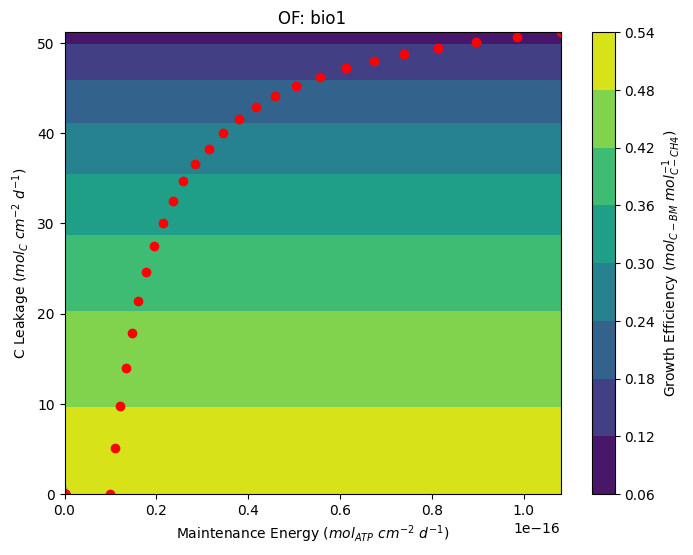

In [21]:
from scipy.interpolate import griddata

# Example data arrays (replace with your data)
x = np.array(maintenance_fig7)  # 1-D array for the first variable (x-axis)
y = np.array(prot_perc_fig7)   # 1-D array for the second variable (y-axis)
z = np.array(gamma_fig7)   # 1-D array for the third variable (z-values)

# Create a grid for interpolation
X, Y = np.meshgrid(x, y)

# Interpolate the Z values to create a 2D grid
Z = griddata((x, y), z, (X, Y), method='nearest')

# Create a contour plot
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, Z, cmap='viridis')
plt.scatter(x,y, c='red')

# Add labels and a colorbar
plt.xlabel('Maintenance Energy ($mol_{ATP}$ $cm^{-2}$ $d^{-1}$)')
plt.ylabel('C Leakage ($mol_C$ $cm^{-2}$ $d^{-1}$)')
plt.title('OF: bio1')
plt.colorbar(contour, label='Growth Efficiency ($mol_{C-BM}$ $mol_{C-CH4}^{-1}$)')

plt.show()


In [22]:
# data for gamma vs. maintenance plot (fixed leakage [0.782 in .json])

# maintenance_fig1 = [
#     9.01E-10,
# 9.91E-10,
# 1.09E-09,
# 1.20E-09,
# 1.32E-09,
# 1.45E-09,
# 1.60E-09,
# 1.76E-09,
# 1.93E-09,
# 2.12E-09,
# 2.34E-09,
# 2.57E-09,
# 2.83E-09,
# 3.11E-09,
# 3.42E-09,
# 3.76E-09,
# 4.14E-09,
# 4.55E-09,
# 5.01E-09,
# 5.51E-09,
# 6.06E-09,
# 6.67E-09,
# 7.33E-09,
# 8.07E-09,
# 8.87E-09,
# 9.76E-09
# ]
maintenance_fig1 = [
1.00E-17,
1.10E-17,
1.21E-17,
1.33E-17,
1.46E-17,
1.61E-17,
1.77E-17,
1.95E-17,
2.14E-17,
2.36E-17,
2.59E-17,
2.85E-17,
3.14E-17,
3.45E-17,
3.80E-17,
4.18E-17,
4.59E-17,
5.05E-17,
5.56E-17,
6.12E-17,
6.73E-17,
7.40E-17,
8.14E-17,
8.95E-17,
9.85E-17,
1.08E-16
]

gamma_fig1 = [
4.72E-01,
4.67E-01,
4.61E-01,
4.55E-01,
4.48E-01,
4.41E-01,
4.33E-01,
4.24E-01,
4.14E-01,
4.03E-01,
3.91E-01,
3.78E-01,
3.63E-01,
3.48E-01,
3.30E-01,
3.11E-01,
2.89E-01,
2.66E-01,
2.40E-01,
2.12E-01,
1.81E-01,
1.47E-01,
1.09E-01,
6.77E-02,
2.26E-02,
0.00E+00
]

main_fine = [
    8.88E-17,
8.97E-17,
9.06E-17,
9.15E-17,
9.23E-17,
9.33E-17,
9.42E-17,
9.52E-17,
9.61E-17,
9.71E-17,
9.81E-17,
9.91E-17,
1.00E-16,
1.01E-16,
1.02E-16,
1.02E-16,
1.02E-16
]

gamma_fine = [
7.16E-02,
6.71E-02,
6.26E-02,
5.81E-02,
5.36E-02,
4.85E-02,
4.40E-02,
3.89E-02,
3.44E-02,
2.93E-02,
2.43E-02,
1.92E-02,
1.47E-02,
9.59E-03,
6.77E-03,
5.64E-03,
3.95E-03
]

1 - gamma_fig1[-2]/gamma_fig1[0]

0.9521186440677966

/var/folders/wt/2cp0_xxj2bq8m7zjv3bk6c180000gn/T/ipykernel_91155/4214395158.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


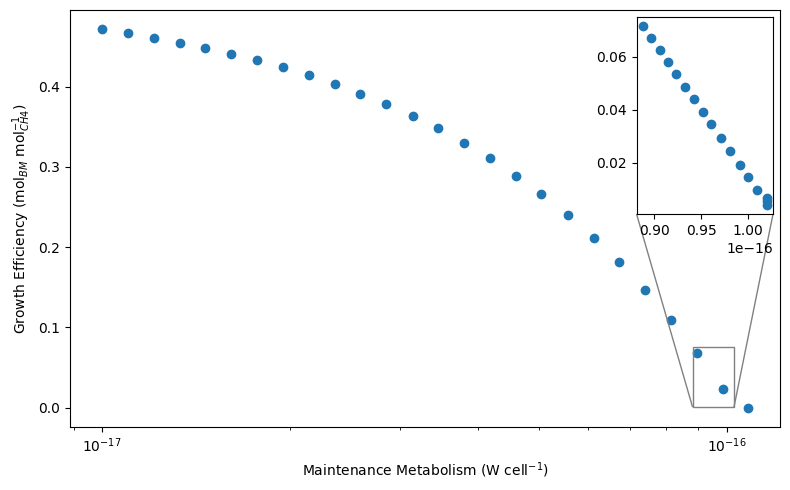

In [23]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes, mark_inset

fig, ax1 = plt.subplots(1,1, figsize=(8,5))

ax1.scatter(maintenance_fig1, gamma_fig1)
# ax.set_xlabel('Maintenance Requirement (mol$_{ATP}$ cm$^{-2}$ d$^{-1}$)')
ax1.set_xlabel('Maintenance Metabolism (W cell$^{-1}$)')
ax1.set_xscale('log')
ax1.set_ylabel('Growth Efficiency (mol$_{BM}$ mol$_{CH4}^{-1}$)')

# ax2.scatter(main_fine, gamma_fine, c='green')
# ax2.set_xlabel('Maintenance Metabolism (W cell$^{-1}$)')
# ax2.set_ylabel('Growth Efficiency (mol$_{BM}$ mol$_{CH4}^{-1}$)')


# Create the inset plot
# axins = inset_axes(ax1, width='30%', height='30%', loc='upper right')
# axins.plot(main_fine, gamma_fine, label='Inset Data', color='red')
# axins.set_title('Inset Plot')
# axins.set_xlabel('X-axis')
# axins.set_ylabel('Y-axis')

# Create a zoomed-inset of the inset plot
axins2 = zoomed_inset_axes(ax1, zoom=3.3, loc='upper right')
axins2.scatter(main_fine, gamma_fine, label='Zoomed Inset Data')
mark_inset(ax1, axins2, loc1=3, loc2=4, fc='none', ec='0.5')

# axins2.set_title('')
# axins2.set_xlabel('Maintenance Metabolism (W cell$^{-1}$)')
# axins2.set_ylabel('Growth Efficiency (mol$_{BM}$ mol$_{CH4}^{-1}$)')


plt.tight_layout()
plt.show()

In [24]:
# fig 2 data
nh4_ub = [
4.04E-02,
1.01E-02,
2.53E-03,
6.31E-04,
1.58E-04,
3.95E-05,
9.86E-06,
2.47E-06,
6.16E-07,
1.54E-07,
3.85E-08,
9.63E-09,
2.41E-09,
6.02E-10,
1.51E-10,
3.76E-11,
9.41E-12,
2.35E-12,
5.88E-13,
1.47E-13,
3.67E-14,
9.19E-15,
2.30E-15,
5.74E-16,
1.44E-16,
3.59E-17
]

gamma_fig2 = [
1.47E-02,
1.47E-02,
1.47E-02,
1.47E-02,
1.47E-02,
1.47E-02,
1.47E-02,
1.47E-02,
1.47E-02,
1.47E-02,
1.47E-02,
1.47E-02,
1.47E-02,
1.47E-02,
1.47E-02,
1.07E-02,
8.96E-03,
8.52E-03,
8.40E-03,
8.38E-03,
8.37E-03,
8.37E-03,
8.37E-03,
8.37E-03,
8.37E-03,
8.37E-03
]

N2_uptake = [
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
4.52E-12,
6.53E-12,
7.04E-12,
7.16E-12,
7.19E-12,
7.20E-12,
7.20E-12,
7.20E-12,
7.20E-12,
7.20E-12,
7.20E-12
]

n2_TN = [
0.00E+00,
0.00E+00,
0.00E+00,
0.00E+00,
0.00E+00,
0.00E+00,
0.00E+00,
0.00E+00,
0.00E+00,
0.00E+00,
0.00E+00,
0.00E+00,
0.00E+00,
0.00E+00,
0.00E+00,
4.90E-01,
8.47E-01,
9.60E-01,
9.90E-01,
9.97E-01,
9.99E-01,
1.00E+00,
1.00E+00,
1.00E+00,
1.00E+00,
1.00E+00
]

nh4_flux = [
2.52E-11,
2.52E-11,
2.52E-11,
2.52E-11,
2.52E-11,
2.52E-11,
2.52E-11,
2.52E-11,
2.52E-11,
2.52E-11,
2.52E-11,
2.52E-11,
2.52E-11,
2.52E-11,
2.52E-11,
9.41E-12,
2.35E-12,
5.88E-13,
1.47E-13,
3.67E-14,
9.19E-15,
2.30E-15,
5.74E-16,
1.44E-16,
0.00E+00,
0.00E+00
]

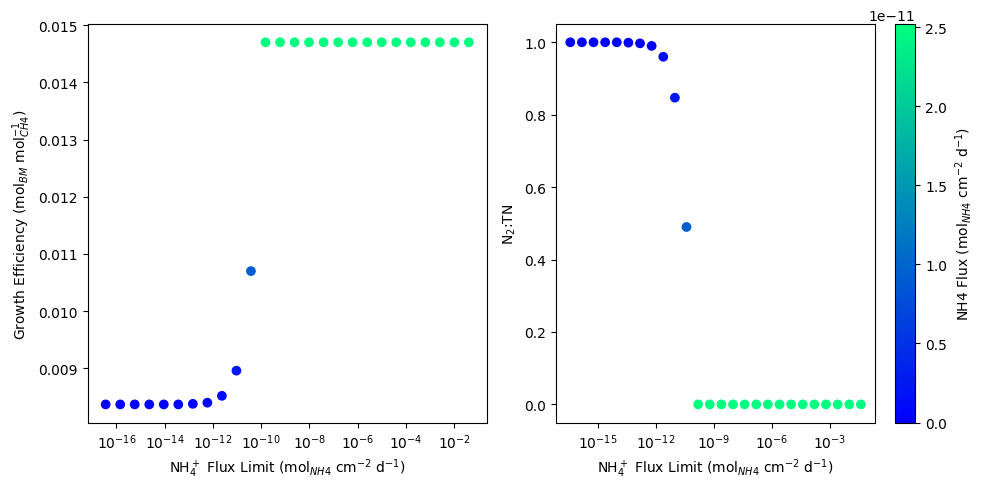

In [25]:
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors

fig, (ax1,ax3) = plt.subplots(1,2, figsize=(10,5))

ax1.scatter(nh4_ub, gamma_fig2, c=nh4_flux, cmap=plt.cm.winter)
ax1.set_xlabel('NH$_4^+$ Flux Limit (mol$_{NH4}$ cm$^{-2}$ d$^{-1}$)')
ax1.set_ylabel('Growth Efficiency (mol$_{BM}$ mol$_{CH4}^{-1}$)')
ax1.set_xscale('log')

# ax2.scatter(nh4_ub, N2_uptake, c=nh4_flux, cmap=plt.cm.winter)
# ax2.set_xlabel('NH$_4^+$ Flux Limit (mol$_{NH4}$ cm$^{-2}$ d$^{-1}$)')
# ax2.set_ylabel('N$_2$ Uptake Flux (mol$_{N2}$ cm$^{-2}$ d$^{-1}$)')
# ax2.set_xscale('log')

ax3.scatter(nh4_ub, n2_TN, c=nh4_flux, cmap=plt.cm.winter)
ax3.set_xlabel('NH$_4^+$ Flux Limit (mol$_{NH4}$ cm$^{-2}$ d$^{-1}$)')
ax3.set_ylabel('N$_2$:TN')
ax3.set_xscale('log')

sm = ScalarMappable(cmap=plt.cm.winter, norm=mcolors.Normalize(vmin=min(nh4_flux), vmax=max(nh4_flux)))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax3, label='NH4 Flux (mol$_{NH4}$ cm$^{-2}$ d$^{-1}$)', cmap=plt.cm.winter)

plt.tight_layout()
plt.show()

In [26]:
gamma_leakage = [
0.014667403,
0.01405468,
0.013436534,
0.012818388,
0.01219482,
0.011582097,
0.010974796,
0.010372917,
0.009787306,
0.009212539,
0.008654039,
0.008111806,
0.00758584,
0.007086985,
0.006604398,
0.006148922,
0.005709714,
0.005297074,
0.004906667,
0.00453849,
0.004192003
]

gamma_fig6 = [
    0.522712621,
0.501077524,
0.479062864,
0.456939757,
0.434870874,
0.41296466,
0.391221117,
0.369857136,
0.348872718,
0.328376311,
0.308476359,
0.289172864,
0.270520049,
0.252626359,
0.235491796,
0.219170583,
0.203608495,
0.188859757,
0.174924369,
0.16180233,
0.149439417,
0.137889854,
0.127099417,
0.11695966,
0.107579029,
0.098849078
]

leakage_fig3 = [
0,
6.15153E-12,
1.23501E-11,
1.85705E-11,
2.47713E-11,
3.09487E-11,
3.7062E-11,
4.30725E-11,
4.89886E-11,
5.47551E-11,
6.0367E-11,
6.57934E-11,
7.10004E-11,
7.60663E-11,
8.08659E-11,
8.55091E-11,
8.98405E-11,
9.4001E-11,
9.79278E-11,
1.01624E-10,
1.05087E-10
]

prot_perc = [
0.00,
5.16,
9.81,
14.02,
17.86,
21.38,
24.57,
27.44,
30.08,
32.48,
34.65,
36.63,
38.43,
40.04,
41.53,
42.88,
44.10,
45.22,
46.23,
47.16,
48.00
]

prot_perc_fig6 = [
    0.00,
5.13,
9.79,
14.02,
17.87,
21.37,
24.56,
27.45,
30.08,
32.47,
34.64,
36.62,
38.24,
40.03,
41.54,
42.87,
44.09,
45.20,
46.23,
47.17,
47.99,
48.74,
49.47,
50.10,
50.67,
51.19
]

nh4_fig3 = [
2.52E-11,
2.60E-11,
2.67E-11,
2.74E-11,
2.81E-11,
2.88E-11,
2.95E-11,
3.02E-11,
3.09E-11,
3.15E-11,
3.22E-11,
3.28E-11,
3.34E-11,
3.39E-11,
3.45E-11,
3.50E-11,
3.55E-11,
3.60E-11,
3.64E-11,
3.69E-11,
3.73E-11
]

nh4_fig6 = [
    9.00E-10,
9.25E-10,
9.50E-10,
9.76E-10,
1.00E-09,
1.03E-09,
1.05E-09,
1.08E-09,
1.10E-09,
1.12E-09,
1.15E-09,
1.17E-09,
1.19E-09,
1.21E-09,
1.23E-09,
1.25E-09,
1.27E-09,
1.28E-09,
1.30E-09,
1.31E-09,
1.33E-09,
1.34E-09,
1.35E-09,
1.37E-09,
1.38E-09,
1.39E-09
]

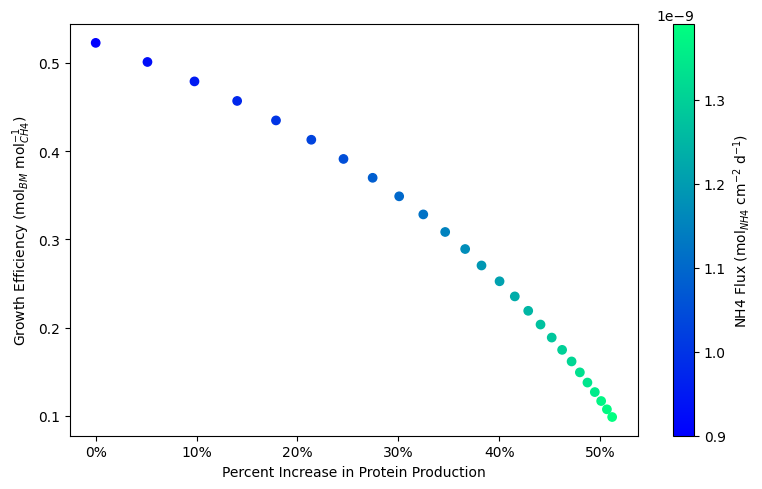

In [27]:
import matplotlib.ticker as mtick

fig, ax = plt.subplots(figsize=(8,5))

# ax.scatter(leakage_fig3, gamma_leakage, c=nh4_fig3, cmap=plt.cm.winter)
ax.scatter(prot_perc_fig6, gamma_fig6, c=nh4_fig6, cmap=plt.cm.winter)
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
# ax.set_xlabel('C-Protein Leakage (mol$_{C}}$ cm$^{-2}$ d$^{-1}$)')
ax.set_xlabel('Percent Increase in Protein Production')
ax.set_ylabel('Growth Efficiency (mol$_{BM}$ mol$_{CH4}^{-1}$)')

sm = ScalarMappable(cmap=plt.cm.winter, norm=mcolors.Normalize(vmin=min(nh4_fig6), vmax=max(nh4_fig6)))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, label='NH4 Flux (mol$_{NH4}$ cm$^{-2}$ d$^{-1}$)', cmap=plt.cm.winter)

plt.tight_layout()
plt.show()

In [28]:
lim_bounds_fig7 = [
    0.00E+00,
1.43E-01,
2.86E-01,
4.29E-01,
5.71E-01,
7.14E-01,
8.57E-01,
1.00E+00
]

H2_flux_fig7 =[
    0.00E+00,
7.97E-10,
1.80E-09,
2.80E-09,
3.80E-09,
4.80E-09,
5.80E-09,
0.00E+00
]

h2_flux_norm = [
    0.00E+00,
1.37E-01,
3.10E-01,
4.83E-01,
6.55E-01,
8.27E-01,
1.00E+00,
0.00E+00
]

co2_flux_fig7 = [
    0.00E+00,
8.00E-10,
1.80E-09,
2.80E-09,
3.80E-09,
4.80E-09,
5.80E-09,
0.00E+00
]

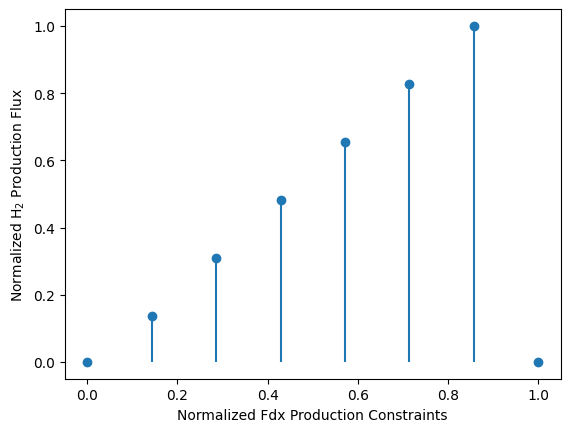

In [29]:
fig, ax = plt.subplots()

fig7 = plt.stem(lim_bounds_fig7, h2_flux_norm, basefmt=' ')
# ax.set_ylabel('H$_2$ Flux (mol$_{H2}$ cm$^{-2}$ d$^{-1}$)')
ax.set_ylabel('Normalized H$_2$ Production Flux')
ax.set_xlabel('Normalized Fdx Production Constraints')

plt.show()

### Imposing NH4 limitation

In [30]:
solutions = []
# for i in range(26):
#     medium_purple['EX_cpd00013_e0'] *= 0.25 #NH4
#     model.medium = medium_purple
#     sol = model.optimize(objective_sense='maximize') # finds an optimal solution for the constraints set above
#     solutions.append(sol) # stores each solution in the list
#     print(f'Simulation {i+1}: {model.summary()}')

In [31]:
ex_flux_dict = {key: [sol.fluxes[key] for sol in solutions] for key in medium_purple.keys()}
ex_flux_dict

{'EX_cpd00067_e0': [],
 'EX_cpd00001_e0': [],
 'EX_cpd00063_e0': [],
 'EX_cpd00058_e0': [],
 'EX_cpd00244_e0': [],
 'EX_cpd00205_e0': [],
 'EX_cpd00013_e0': [],
 'EX_cpd00009_e0': [],
 'EX_cpd00034_e0': [],
 'EX_cpd10516_e0': [],
 'EX_cpd11574_e0': [],
 'EX_cpd00971_e0': [],
 'EX_cpd00149_e0': [],
 'EX_cpd00254_e0': [],
 'EX_cpd00048_e0': [],
 'EX_cpd10515_e0': [],
 'EX_cpd00099_e0': [],
 'EX_cpd00528_e0': [],
 'EX_cpd01024_e0': [],
 'EX_cpd11640_e0': [],
 'EX_cpdAQDS_e0': []}

In [32]:
t_NH4 = [math.fabs(sol.fluxes['EX_cpd00013_e0']) for sol in solutions]
t_N2 = [math.fabs(sol.fluxes['EX_cpd00528_e0']) for sol in solutions]
t_ch4 = [math.fabs(sol.fluxes['EX_cpd01024_e0']) for sol in solutions]
t_bm = [sol.fluxes['bio1'] for sol in solutions]
t_protein = [sol.fluxes['rxn05296_c0'] for sol in solutions]
t_mrna = [sol.fluxes['rxn05295_c0'] for sol in solutions]

print(f'protein: {t_protein} \nmrna:{t_mrna}')

protein: [] 
mrna:[]


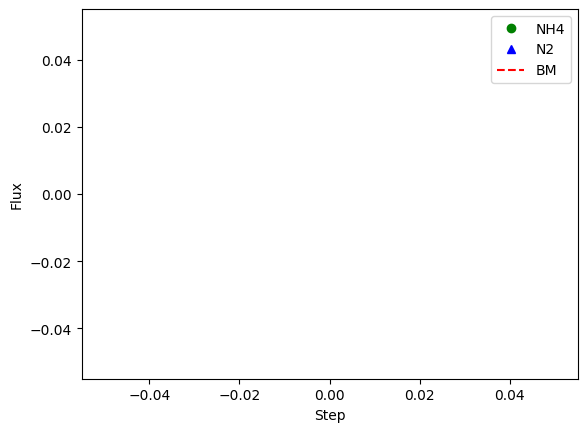

In [33]:
line_Nh4, = plt.plot(t_NH4, 'go', label='NH4')
line_N2, = plt.plot(t_N2, 'b^', label='N2')
line_bm, = plt.plot(t_bm, 'r--', label='BM')
# line_ch4, = plt.plot(t_ch4, 'yX', label='CH4')
leg = plt.legend()
plt.ylabel('Flux')
plt.xlabel('Step')
plt.show()

### Using Pareto compare to see how two objective functions interact

In [34]:
def compute_pareto_optimality(model_json_file, rxn1, rxn2, medium, dinc=0.001, FVAflag=False):
    # Load the JSON model file
    model = cobra.io.load_json_model(model_json_file)
    model.tolerance = 1E-16
    model.medium = medium

    # Find the range of possible optimal values for both objective functions
    with model:
        model.reactions.get_by_id(rxn1).objective_coefficient = 1
        solution = model.optimize()
        dmaxRxn1 = solution.objective_value

        model.reactions.get_by_id(rxn1).objective_coefficient = -1
        solution = model.optimize()
        dminRxn1 = solution.objective_value

        model.reactions.get_by_id(rxn2).objective_coefficient = 1
        solution = model.optimize()
        dmaxRxn2 = solution.objective_value

        model.reactions.get_by_id(rxn2).objective_coefficient = -1
        solution = model.optimize()
        dminRxn2 = solution.objective_value

    # Start the computation of the Pareto frontier
    ParetoFrontier = []
    ParetoFrontier.append(["Index", rxn1, rxn2])

    cnt = 1
    fluxSolutions = []
    minFluxes = []
    maxFluxes = []

    # Optimize the second reaction and fix the flux through the first reaction
    for i in np.arange(dminRxn1, dmaxRxn1 + dinc, dinc):
        with model:
            model.reactions.get_by_id(rxn1).bounds = (i, i)
            model.reactions.get_by_id(rxn2).objective_coefficient = 1
            solution = model.optimize()
            if solution.status == 'optimal':
                ParetoFrontier.append([i, solution.fluxes[rxn1], solution.fluxes[rxn2]])
                fluxSolutions.append(solution)
            else:
                ParetoFrontier.append([i, np.nan, np.nan])
            if FVAflag:
                min_flux, max_flux = cobra.flux_analysis.flux_variability_analysis(model, fraction_of_optimum=0.999)
                minFluxes.append(min_flux)
                maxFluxes.append(max_flux)
        cnt += 1

    # Optimize the first reaction and fix the flux through the second reaction
    for i in np.arange(dminRxn2, dmaxRxn2 + dinc, dinc):
        with model:
            model.reactions.get_by_id(rxn2).bounds = (i, i)
            model.reactions.get_by_id(rxn1).objective_coefficient = 1
            solution = model.optimize()
            if solution.status == 'optimal':
                ParetoFrontier.append([i, solution.fluxes[rxn1], solution.fluxes[rxn2]])
                fluxSolutions.append(solution)
            else:
                ParetoFrontier.append([i, np.nan, np.nan])
            if FVAflag:
                min_flux, max_flux = cobra.flux_analysis.flux_variability_analysis(model, fraction_of_optimum=0.999)
                minFluxes.append(min_flux)
                maxFluxes.append(max_flux)
        cnt += 1

    return ParetoFrontier, fluxSolutions, minFluxes, maxFluxes

In [35]:
model_json_file = './final/anme_ANME2b.json'
rxn1 = "bio1"
rxn2 = 'rxnAQDS_c0'
# rxn2 = 'bio2'
medium = medium_mmol_gdw_hr
# ParetoFrontier, fluxSolutions, minFluxes, maxFluxes = compute_pareto_optimality(model_json_file, rxn1, rxn2, medium, dinc=1E-9)

# ParetoFrontier

NameError: name 'medium_mmol_gdw_hr' is not defined

In [ ]:
import csv

fields = ParetoFrontier[0]
rows = ParetoFrontier[1:]

# with open('pareto_comp_bio1_aqds.csv', 'w') as f:
     
#     # using csv.writer method from CSV package
#     write = csv.writer(f)
     
#     write.writerow(fields)
#     write.writerows(rows)